# Description

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this task, we have to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import warnings
import re
import spacy

nlp = spacy.load('en_core_web_sm')

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
data.shape

(7613, 5)

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
def plotBarGraph(res, column_name, start=0, top=10, show=False, rotate=False):
    plt.figure(figsize=(15, 6))
    plt.bar(res[column_name][start:top], res['count'][start:top])
    plt.xlabel(column_name, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title(f'{column_name} Frequency', fontsize=16)

    for i, value in enumerate(res['count'][start:top]):
        plt.text(res[column_name][start + i], value + 0.5, str(value), ha='center', fontsize=16)
        
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    if rotate:
        plt.xticks(rotation=90)

    if show:
        plt.savefig(f'{column_name}_freq.png')
        plt.show()
    else:
        plt.show()

# Data Distribution

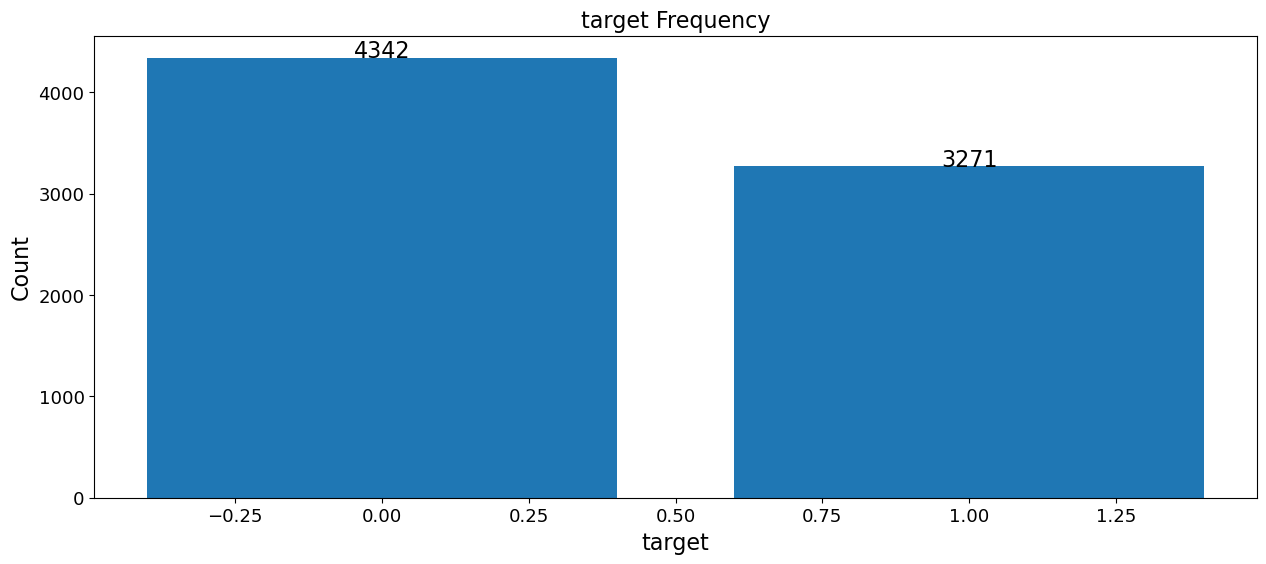

In [78]:
plotBarGraph(pd.DataFrame(data['target'].value_counts()).reset_index().rename(columns={'index':'target','target':'count'}), column_name='target')

In [5]:
set(data['target'])

{0, 1}

# Distribution of tweet length

<Axes: xlabel='tweet_length', ylabel='Density'>

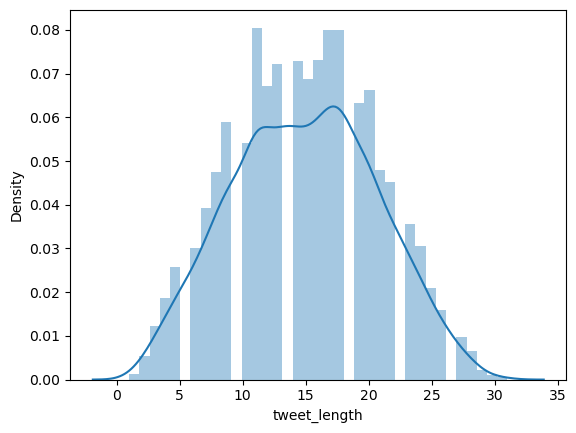

In [6]:
import seaborn as sns
data['tweet_length'] = data['text'].apply(lambda text: len(text.split()))
sns.distplot(data['tweet_length'])

# Distribution of tweets length by target

Text(0.5, 1.0, 'target = 1 (disaster)')

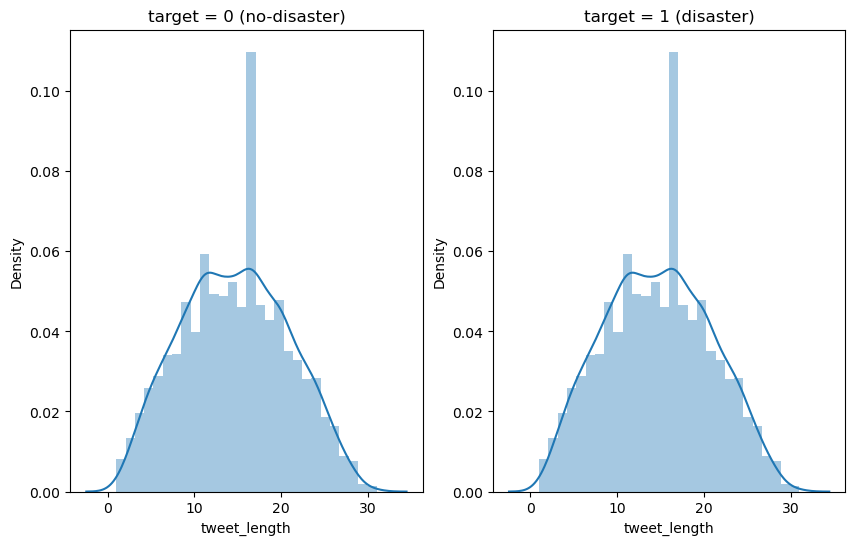

In [7]:
import seaborn as sns
_,ax = plt.subplots(1,2, figsize=(10,6))
sns.distplot(data['tweet_length'][data['target'] == 0], ax=ax[0])
ax[0].set_title("target = 0 (no-disaster)")
sns.distplot(data['tweet_length'][data['target'] == 0], ax=ax[1])
ax[1].set_title("target = 1 (disaster)")

In [8]:
data[~data['keyword'].isnull()]

,id,keyword,location,text,target,tweet_length
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,5
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,10
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,9
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,7
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,13
...,...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0,7
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,20
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,12
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,13


In [5]:
import re

def clean_tweet(tweet, for_eda=False):
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    
    tweet = re.sub(r'#', ' ', tweet)
    
    # Remove mentions
    tweet = re.sub(r'\@\w+', '', tweet)
    
    # Remove special characters and punctuations
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Remove emoticons
    #tweet = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove extra whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    if for_eda:
        tokens = tweet.split()
        lemmatized_tokens = [token.lemma_ for token in nlp(tweet) if not token.is_stop and token.is_alpha and len(token)>1]
        tweet = " ".join(lemmatized_tokens)
        
    return tweet

In [11]:
data['text'][31]

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

In [10]:
data['cleaned_text_for_eda'] = data['text'].apply(clean_tweet, args=[True])
data['cleaned_text_for_eda'][31]

'wholesale market ablaze'

# Most frquent words in disaster related tweets

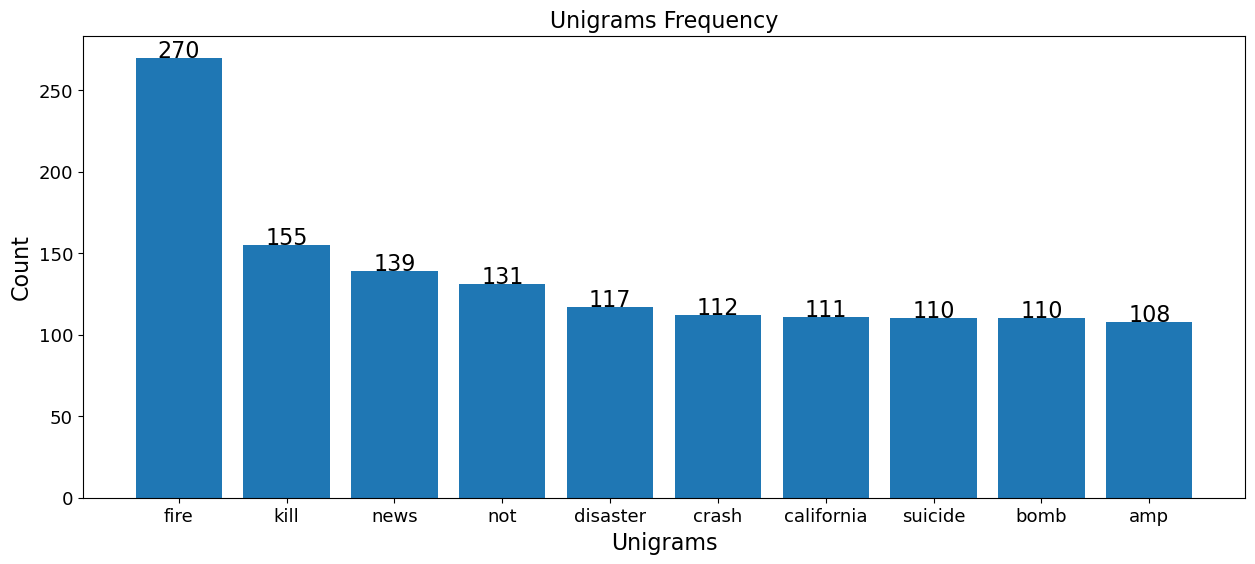

In [13]:
tokenized_texts_1 = [text.split() for text in data['cleaned_text_for_eda'][data['target'] == 1].values]

# Count word frequency
unigram_word_frequency = Counter()
for tokens in tokenized_texts_1:
    unigram_word_frequency.update(tokens)
    
res = pd.DataFrame(unigram_word_frequency.most_common(10), columns=['Unigrams', 'count'])
    
plotBarGraph(res,column_name="Unigrams")

# Most frquent words in non- disaster related tweets

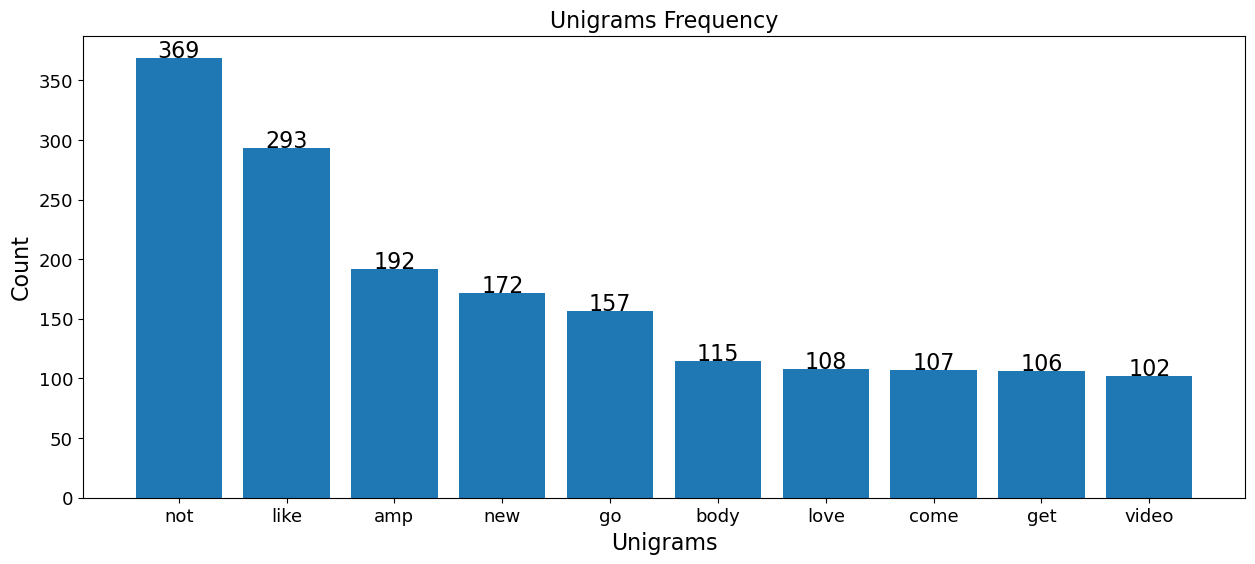

In [11]:
tokenized_texts_0 = [text.split() for text in data['cleaned_text_for_eda'][data['target'] == 0].values]

# Count word frequency
unigram_word_frequency = Counter()
for tokens in tokenized_texts_0:
    unigram_word_frequency.update(tokens)
    
res = pd.DataFrame(unigram_word_frequency.most_common(10), columns=['Unigrams', 'count'])
    
plotBarGraph(res,column_name="Unigrams")

Text(0.5, 1.0, 'Words in Disaster Tweets')

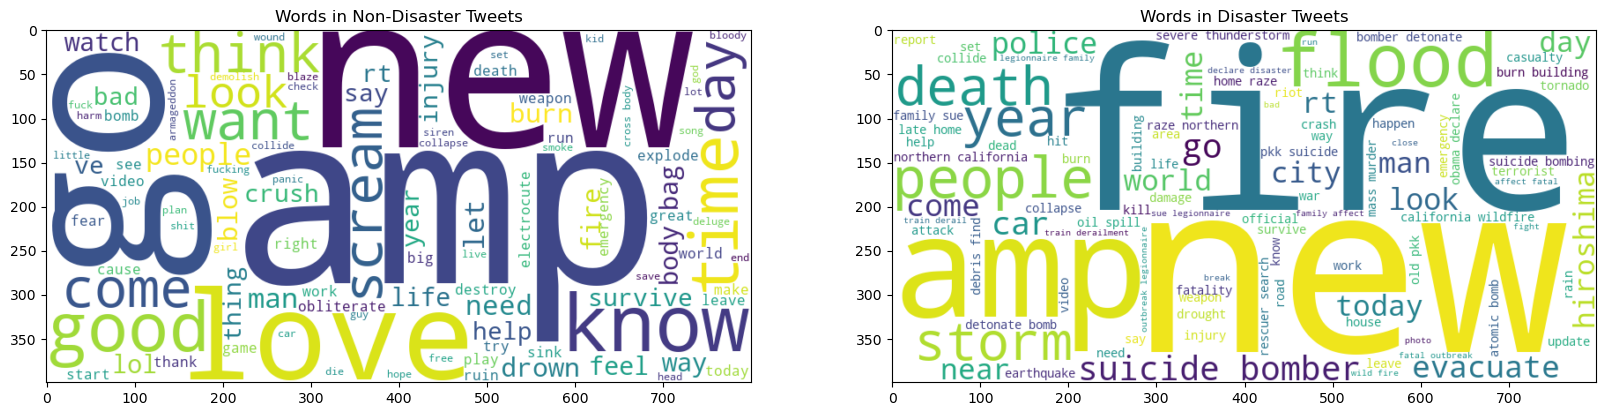

In [15]:
tokenized_texts_0_sentence = " ".join([word for word_list in tokenized_texts_0 for word in word_list])
tokenized_texts_1_sentence = " ".join([word for word_list in tokenized_texts_1 for word in word_list])

_,ax = plt.subplots(1,2,figsize=(20,10) )
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', contour_width=3, 
                      contour_color='steelblue', max_words=100).generate(tokenized_texts_0_sentence)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].set_title("Words in Non-Disaster Tweets")

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', contour_width=3, 
                      contour_color='steelblue', max_words=100).generate(tokenized_texts_1_sentence)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].set_title("Words in Disaster Tweets")

# Most frquent bigrams in disaster related tweets

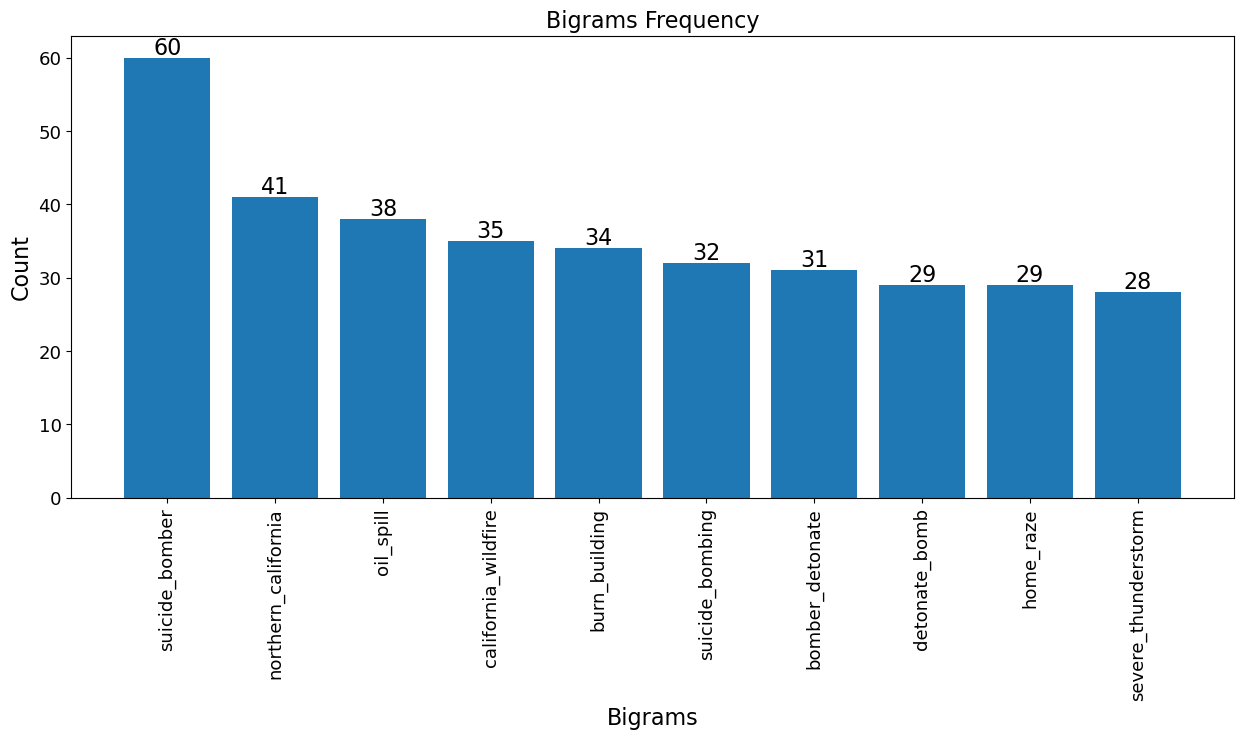

In [16]:
import nltk
from nltk import bigrams, ngrams
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

# Generate bigrams from the tokenized data
all_bigrams_tokenized_texts_1 = [list(bigrams(sentence)) for sentence in tokenized_texts_1]

# Flatten the list of bigrams
all_bigrams_tokenized_texts_1_flat = [bigram for sentence_bigrams in all_bigrams_tokenized_texts_1 for bigram in sentence_bigrams]

# Calculate the frequency distribution of the bigrams
freq_dist = FreqDist(all_bigrams_tokenized_texts_1_flat)

# Get the top 10 most frequent bigrams
top_10_bigrams = freq_dist.most_common(10)

# Extract the bigrams and their frequencies
bigrams, bigrams_frequencies = zip(*top_10_bigrams)

bigrams = ["_".join(bigram) for bigram in bigrams]

res = pd.DataFrame(zip(bigrams,bigrams_frequencies), columns=['Bigrams', 'count'])
    
plotBarGraph(res,column_name="Bigrams",start=0, rotate=True)

# Most frquent bigrams in non-disaster related tweets

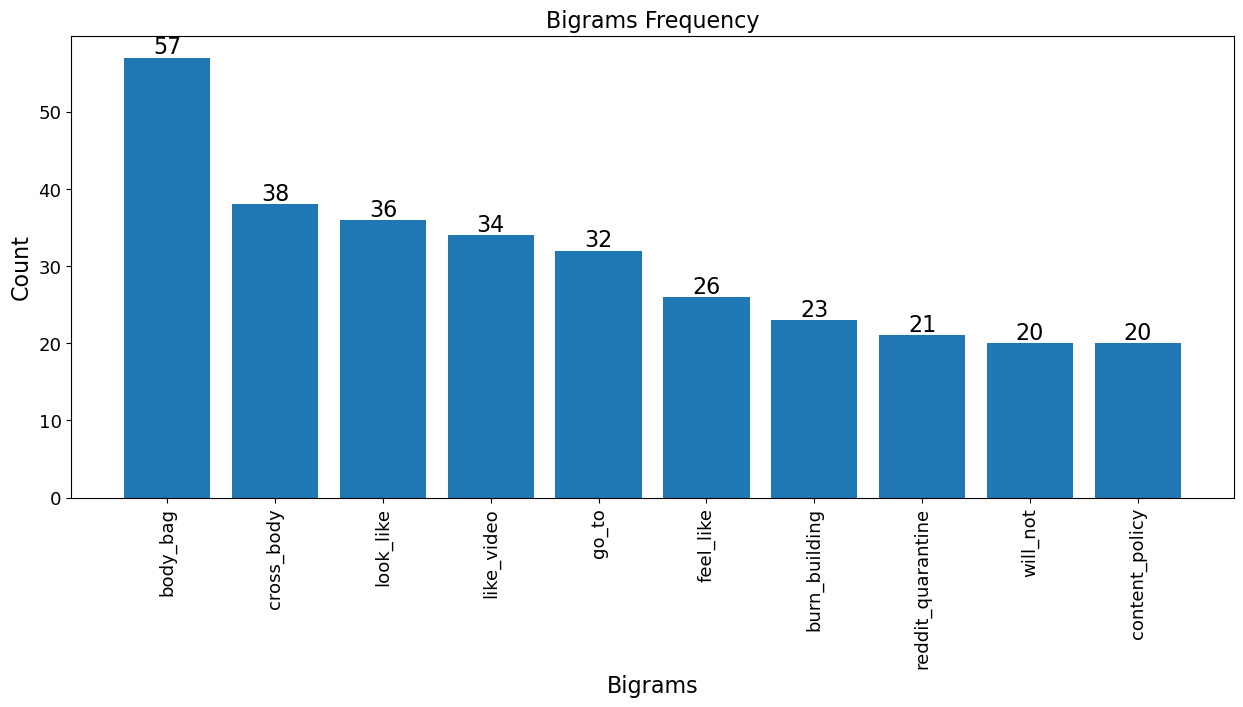

In [17]:
import nltk
from nltk import bigrams, ngrams
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

lens = pd.Series(tokenized_texts_0).apply(lambda x: len(x))
# Generate bigrams from the tokenized data
all_bigrams_tokenized_texts_0 = [list(bigrams(sentence)) for sentence in pd.Series(tokenized_texts_0)[lens!=0].values]

# Flatten the list of bigrams
all_bigrams_tokenized_texts_0_flat = [bigram for sentence_bigrams in all_bigrams_tokenized_texts_0 for bigram in sentence_bigrams]

# Calculate the frequency distribution of the bigrams
freq_dist = FreqDist(all_bigrams_tokenized_texts_0_flat)

# Get the top 10 most frequent bigrams
top_10_bigrams = freq_dist.most_common(10)

# Extract the bigrams and their frequencies
bigrams, bigrams_frequencies = zip(*top_10_bigrams)

bigrams = ["_".join(bigram) for bigram in bigrams]

res = pd.DataFrame(zip(bigrams,bigrams_frequencies), columns=['Bigrams', 'count'])
    
plotBarGraph(res,column_name="Bigrams",start=0, rotate=True)

# Lets analyze topics related to disaster tweets

In [ ]:
#!pip install bertopic

In [18]:
from bertopic import BERTopic

preprocessed_text = data['cleaned_text_for_eda'][data['target']==1].values

# Initialize BERTopic model with ClinicalBERT tokenizer and model
topic_model = BERTopic(nr_topics=16, min_topic_size=3)

# Fit the model to the documents
topics, _ = topic_model.fit_transform(preprocessed_text)
top_words = topic_model.get_topics()

# Below are main topics being discussed in Disaster related tweets. Note that topic -1 is outlier topic

In [19]:
topic_representation = {}
top= 5
for topic_id, words in top_words.items():
    topic_representation[topic_id] = "|".join([word[0] for word in words[:top]])
    
topic_representation

{-1: 'fire|not|amp|car|like',
 0: 'fire|flood|california|disaster|wildfire',
 1: 'suicide|hiroshima|bomb|attack|nuclear',
 2: 'crash|malaysia|debris|wreckage|confirm',
 3: 'police|mass|wound|officer|charge',
 4: 'train|derailment|derail|collision|accident',
 5: 'legionnaire|family|outbreak|sue|affect',
 6: 'oil|spill|sinkhole|costlier|refugio',
 7: 'migrant|hundred|rescuer|search|boat',
 8: 'refugee|food|famine|provoke|crematoria',
 9: 'earthquake|km|volcano|seismic|hawaii',
 10: 'detonation|ignition|mop|knock|apollo',
 11: 'aba|deliver|pandemonium|woman|baby',
 12: 'hollywood|miner|trap|movie|chile',
 13: 'blk|auth|wbioterrorismampuse|lglorg|idi',
 14: 'inner|silver|exit|md|loop'}

In [20]:
topic_model.set_topic_labels(topic_representation)

# Below plot shows 16 different topics which are almost clearly sprarated 

In [31]:
#!pip install -U kaleido
# !pip install psutil requests
# !pip install plotly>=5.0.0
from plotly.io import to_image
from IPython.display import Image

In [28]:
fig = topic_model.visualize_topics(custom_labels=True)
image_bytes = to_image(fig, format='png')

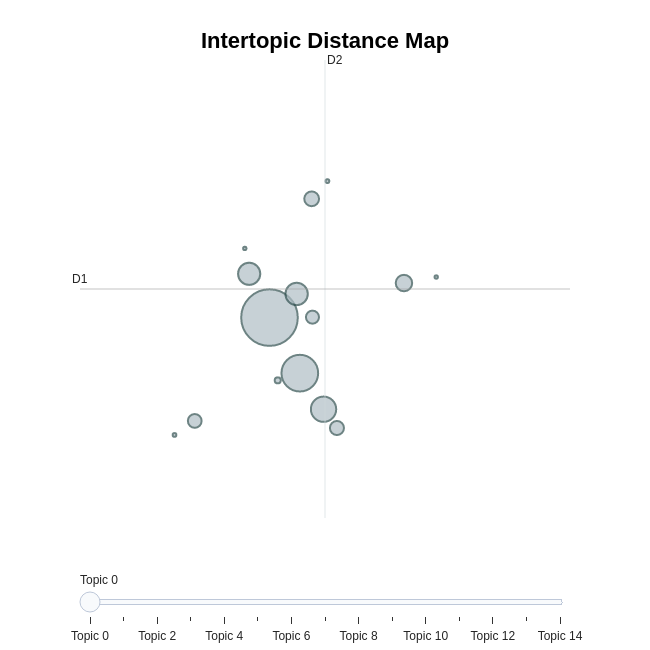

In [30]:
Image(image_bytes)

# Below is most frequent top 10 words from each topic

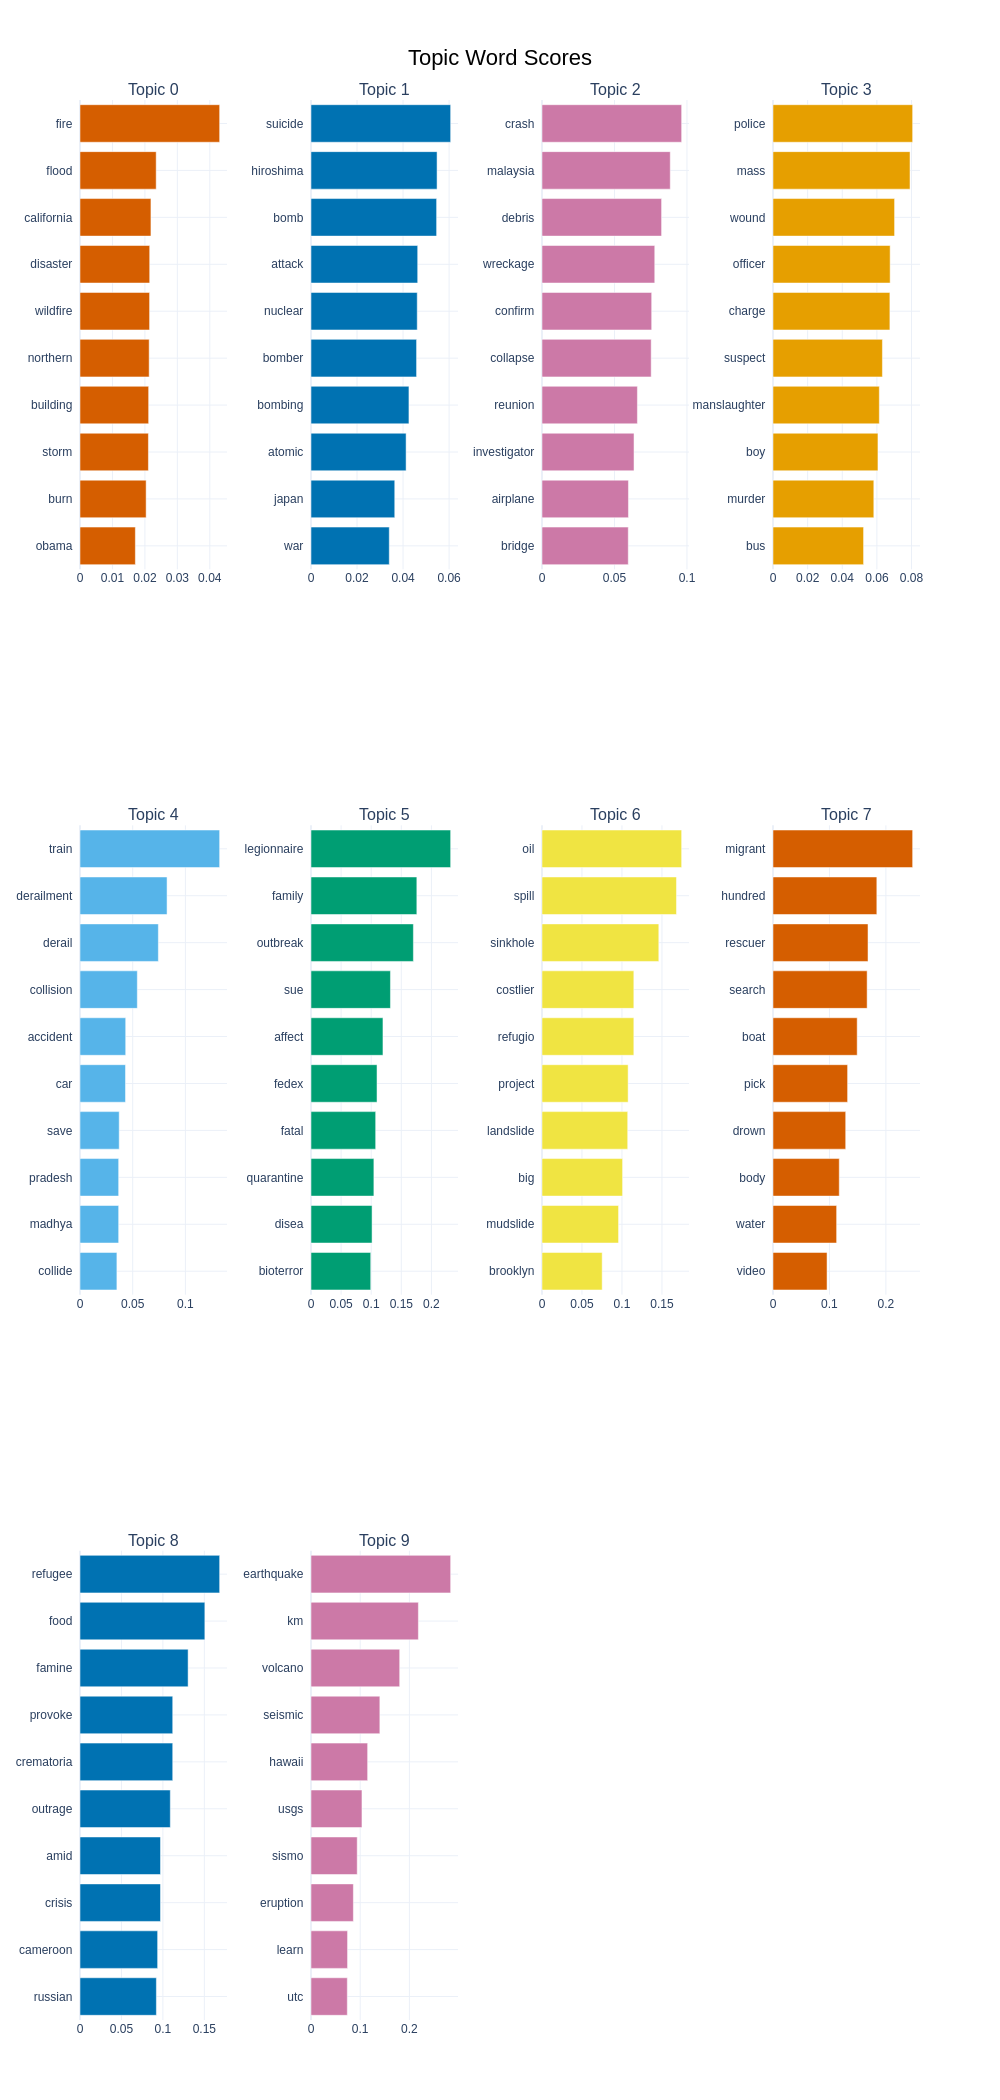

In [32]:
fig = topic_model.visualize_barchart(top_n_topics=10, n_words=10, height=700)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Below plot the similarity among each topic

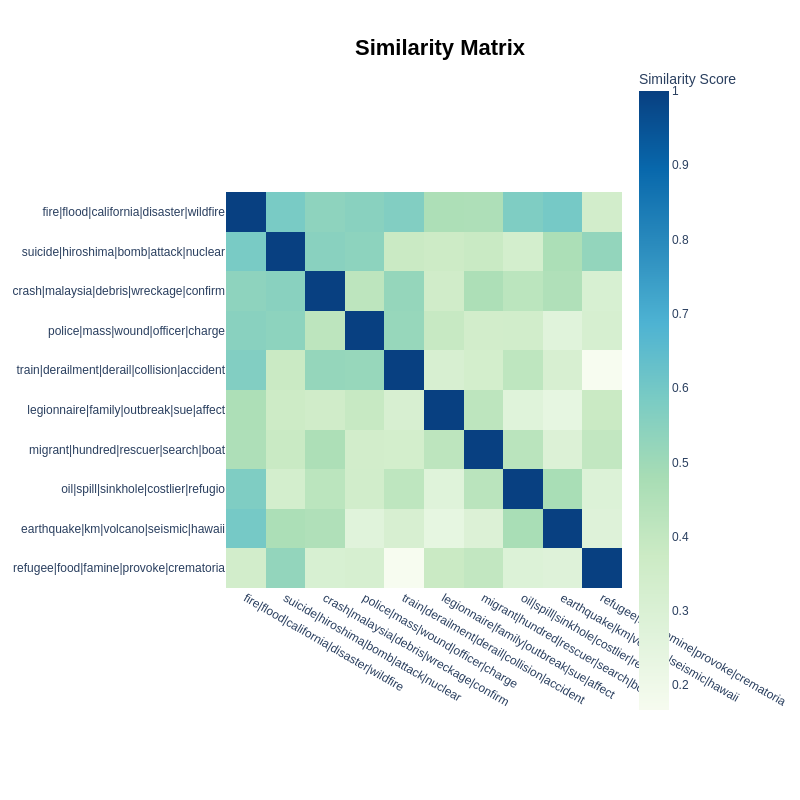

In [33]:
fig = topic_model.visualize_heatmap(n_clusters=4, top_n_topics=10, custom_labels=True, width = 800, height = 800)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Analyzing topics being discussed in Non- Disaster related tweets

In [38]:
from bertopic import BERTopic

preprocessed_text = data['cleaned_text_for_eda'][data['target']==0].values

# Initialize BERTopic model with ClinicalBERT tokenizer and model
topic_model_0 = BERTopic(nr_topics=16, min_topic_size=3)

# Fit the model to the documents
topics_0, _ = topic_model_0.fit_transform(preprocessed_text)
top_words_0 = topic_model_0.get_topics()

# Below are main topics being discussed in NON-Disaster realted tweets.

In [39]:
topic_representation = {}
top= 5
for topic_id, words in top_words_0.items():
    topic_representation[topic_id] = "|".join([word[0] for word in words[:top]])
    
topic_representation

{-1: 'not|amp|like|day|good',
 0: 'not|like|go|video|love',
 1: 'quarantine|reddit|content|offensive|nuclear',
 2: 'emergency|curfew|job|service|plan',
 3: 'bag|body|cross|handbag|shoulder',
 4: 'electrocute|detonate|ignition|detonation|knock',
 5: 'rescue|fedex|dog|horse|bioterror',
 6: 'deluge|business|tv|seismic|cable',
 7: 'blight|space|light|fleet|involve',
 8: 'army|pick|fan|directioner|beyhive',
 9: 'hijacking|funtenna|prebreak|hat|datum',
 10: 'aba|deliver|wedding|pandemonium|syrian',
 11: 'ancient|canaanite|mayan|tablet|order',
 12: 'miner|hollywood|trap|chile|movie',
 13: 'scheme|chicagoarea|admit|arson|owner',
 14: 'thank|sweet|super|awesome|beautiful'}

In [40]:
topic_model_0.set_topic_labels(topic_representation)

# Below plot shows 16 different topics alomost clearly sprarated 

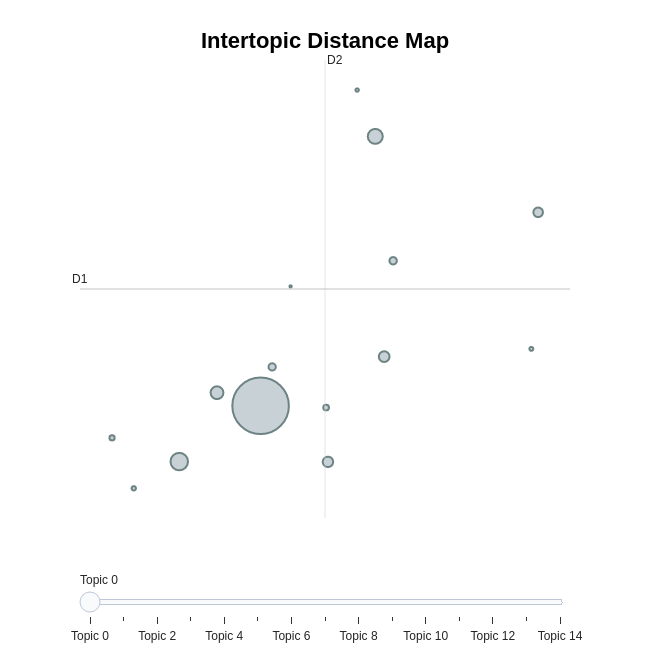

In [41]:
fig = topic_model_0.visualize_topics(custom_labels=True)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Below is most frequent top 10 words from each topic

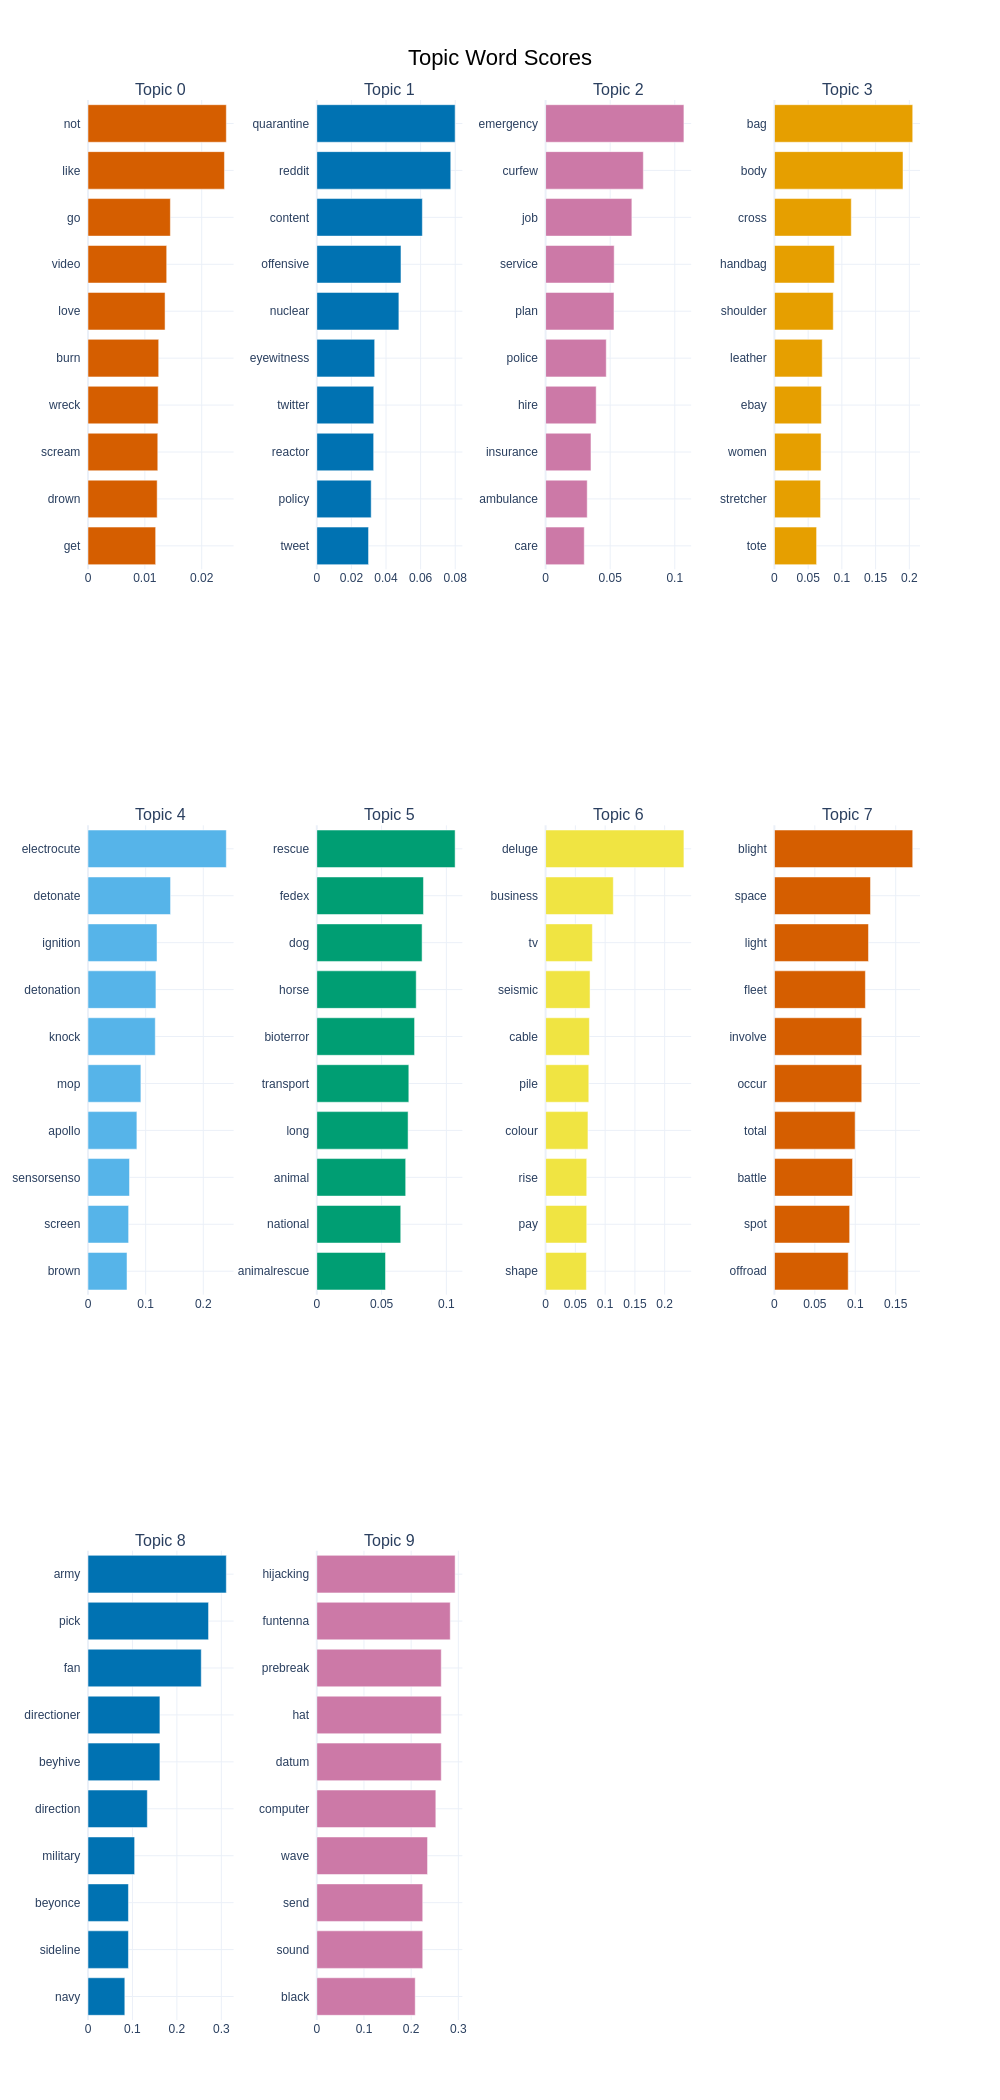

In [42]:
fig = topic_model_0.visualize_barchart(top_n_topics=10, n_words=10, height=700)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Below plot the similarity among each topic

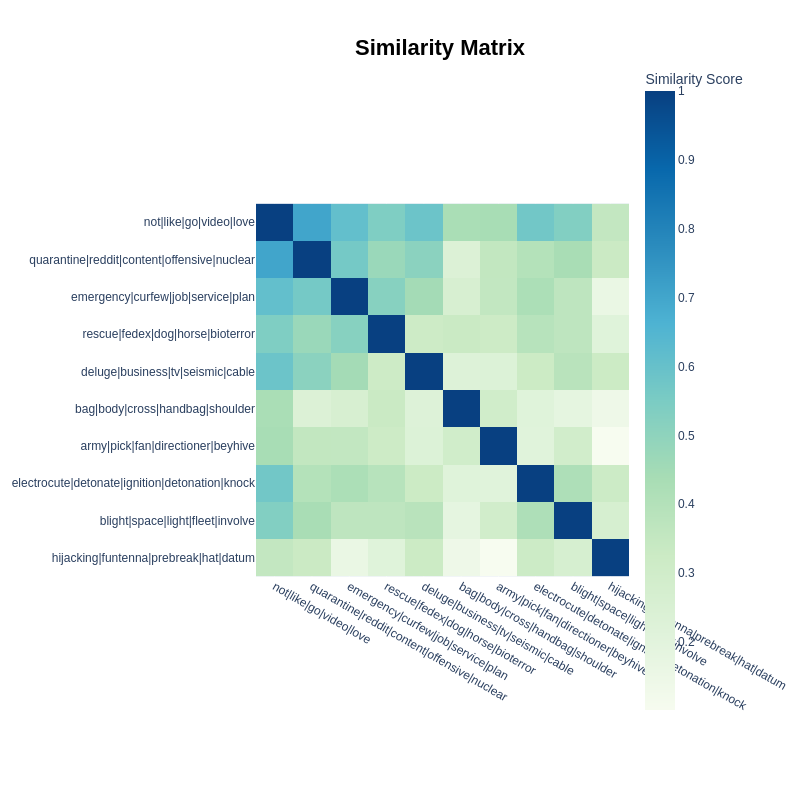

In [43]:
fig = topic_model_0.visualize_heatmap(n_clusters=4, top_n_topics=10, custom_labels=True, width = 800, height = 800)
image_bytes = to_image(fig, format='png')
Image(image_bytes)

# Model building

# Using Roberta model trained on tweets and finetuned on semement analysis task to futher finetune on this task

In [6]:
data['text'] = data['text'].apply(clean_tweet)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

batch_size = 10


model_name = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)
bert_model.trainable = True

#Define the classification model
input_ids = Input(shape=(None,), name='input_ids', dtype=tf.int32)
attention_mask = Input(shape=(None,), name='attention_mask', dtype=tf.int32)
pooled_output = bert_model(input_ids, attention_mask).pooler_output
dense_1 = Dense(512, activation='tanh')(pooled_output)
dropout_1 = Dropout(0.5)(dense_1)

dense_2 = Dense(256, activation='tanh')(dropout_1)
dropout_2 = Dropout(0.5)(dense_2)

dense_3 = Dense(128, activation='tanh')(dropout_2)
dropout_3 = Dropout(0.5)(dense_3)
outputs = Dense(1, activation='sigmoid')(dropout_3)

model = Model(inputs=[input_ids, attention_mask], outputs=outputs)


optimizer = Adam(learning_rate=.000002)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


X_train, X_test, y_train, y_test = train_test_split(data['text'].values, data['target'].values, test_size=0.1, random_state=42)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)


train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y_train
)).shuffle(len(train_encodings['input_ids'])).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    y_test
)).batch(batch_size)

model.summary()

Some layers from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaModel were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized: ['roberta/pooler/dense/bias:0', 'roberta/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, None                                           

In [9]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=2,           
    restore_best_weights=True  
)

In [10]:
num_epochs = 15
history  = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)


Epoch 1/15
686/686 [==============================] - 169s 171ms/step - loss: 0.6041 - accuracy: 0.6714 - val_loss: 0.4766 - val_accuracy: 0.7861
Epoch 2/15
686/686 [==============================] - 92s 134ms/step - loss: 0.4463 - accuracy: 0.8215 - val_loss: 0.4337 - val_accuracy: 0.8176
Epoch 3/15
686/686 [==============================] - 96s 140ms/step - loss: 0.3988 - accuracy: 0.8467 - val_loss: 0.4158 - val_accuracy: 0.8412
Epoch 4/15
686/686 [==============================] - 92s 134ms/step - loss: 0.3722 - accuracy: 0.8596 - val_loss: 0.4476 - val_accuracy: 0.8241
Epoch 5/15
686/686 [==============================] - 92s 134ms/step - loss: 0.3426 - accuracy: 0.8710 - val_loss: 0.4679 - val_accuracy: 0.8241


# Analysize and plot between train and val loss

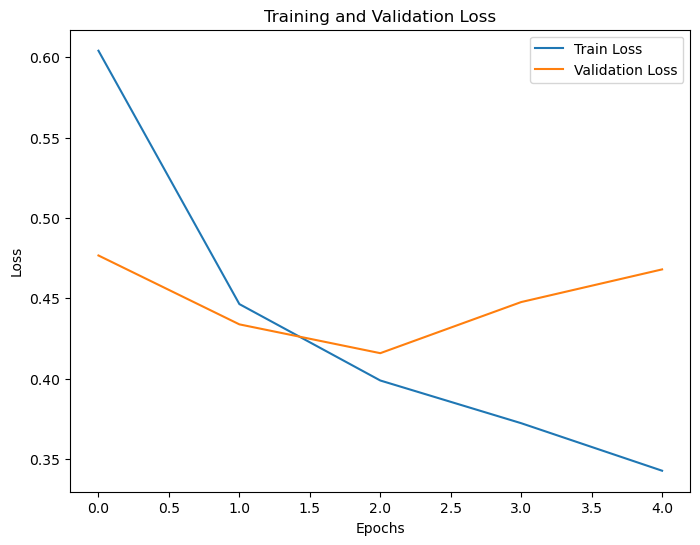

In [11]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# below is a helper funtion to get prediction for each record

In [12]:
def get_prediction(sentence):

    tokens = tokenizer(sentence, padding=True, truncation=True, return_tensors="tf")

    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    outputs = model.predict([input_ids,attention_mask], verbose=0)
    
    return outputs[0][0]

# I will use AUC-ROC plot to come-up with best probability threshold for this task

# Verify probability threshold for best accuracy

In [14]:
roc_test = pd.Series(X_test)

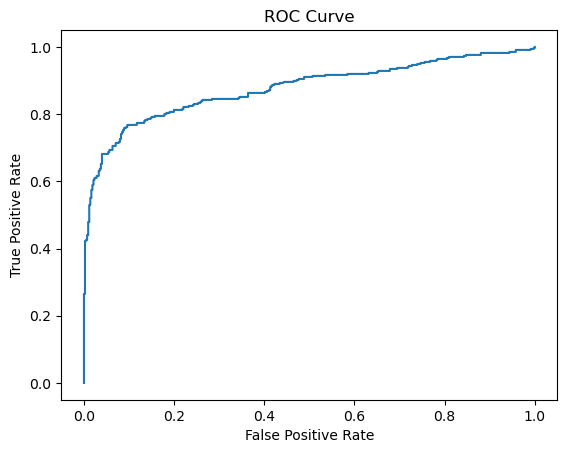

AUC value: 0.8764496702436844


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score


# Generate some data
y_true = y_test
y_score = roc_test.apply(get_prediction)

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_value = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Print the AUC value
print("AUC value:", auc_value)

# I have played a little here with different probabity values

In [23]:
def get_target(outputs):
    sentiment = [1 if output>=0.54 else 0 for output in outputs]
    return sentiment

y_pred = get_target(y_score)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.8438320209973753


In [56]:
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

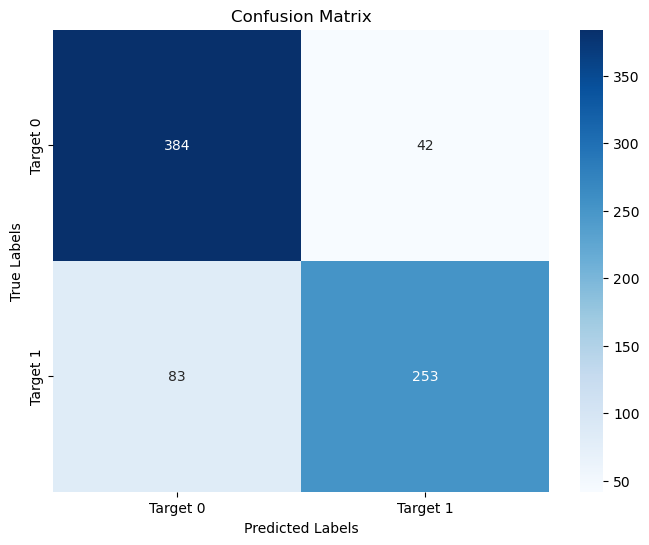

In [57]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_test, y_pred)
class_labels = ['Target 0', 'Target 1']
plot_confusion_matrix(confusion_mat, class_labels)

# Finally Make Prediction on test data

In [90]:
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test['text'] = test['text'].apply(clean_tweet)
y_score = test['text'].apply(get_prediction)

In [91]:
def get_target(outputs):
    sentiment = [1 if output>=0.54 else 0 for output in outputs]
    return sentiment

y_pred = get_target(y_score)

# Lets verify the result

In [93]:
def get_tag(label):
    if label == 1:
        return 'Disaster'
    else:
        return 'NoT a Disaster'

In [94]:
for ind in range(20):
    print(f"Text: {test['text'][ind]}, prediction : {get_tag(y_pred[ind])}")
    print('-------------------')

Text: just happened a terrible car crash, prediction : Disaster
-------------------
Text: heard about earthquake is different cities stay safe everyone, prediction : Disaster
-------------------
Text: there is a forest fire at spot pond geese are fleeing across the street i cannot save them all, prediction : Disaster
-------------------
Text: apocalypse lighting spokane wildfires, prediction : Disaster
-------------------
Text: typhoon soudelor kills 28 in china and taiwan, prediction : Disaster
-------------------
Text: were shakingits an earthquake, prediction : Disaster
-------------------
Text: theyd probably still show more life than arsenal did yesterday eh eh, prediction : NoT a Disaster
-------------------
Text: hey how are you, prediction : NoT a Disaster
-------------------
Text: what a nice hat, prediction : NoT a Disaster
-------------------
Text: fuck off, prediction : NoT a Disaster
-------------------
Text: no i dont like cold, prediction : NoT a Disaster
---------------

In [92]:
sample_submission = pd.DataFrame()
sample_submission['id']=test['id']
sample_submission['target']=y_pred
sample_submission.to_csv("submission.csv", index=False)